# Tópico 13 – Bootstrapping [<img src="images/colag_logo.svg" style="float: right; vertical-align: middle; width: 42px; height: 42px;">](https://colab.research.google.com/github/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2013/13%20%E2%80%93%20Bootstrapping.ipynb) [<img src="images/github_logo.svg" style="float: right; margin-right: 12px; vertical-align: middle; width: 36px; height: 36px;">](https://github.com/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2013/13%20%E2%80%93%20Bootstrapping.ipynb)

Nessa aula, vamos aprender como quantificar a incerteza sobre nossas estimativas e como aplicar uma técnica pioneira que nos permite, com base em uma única amostra, simular diferentes cenários possíveis para as nossas estimativas.

### Resultados Esperados

1. Entender mais sobre o papel das distribuições amostrais na quantificação de incerteza sobre nossas estimativas.
1. Aprender sobre as potencialidades do bootstrap, e aprender como operacionalizá-lo na prática.
1. Introduzir os conceitos de percentis e como usá-los nesse contexto.

### Referências
- [CIT, Capítulo 13](https://inferentialthinking.com/)

Material adaptado do [DSC10 (UCSD)](https://dsc10.com/) por [Flavio Figueiredo (DCC-UFMG)](https://flaviovdf.io/fcd/) e [Uriel Silva (DEST-UFMG)](https://urielmoreirasilva.github.io)

In [2]:
# Imports para esse tópico.
import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Opções de como printar objetos do Numpy e do Pandas.
np.set_printoptions(threshold = 20, precision = 2, suppress = True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

### Exemplo motivador: Salários dos funcionários públicos da cidade de San Diego

Vamos começar essa aula com um exemplo motivador: [os salários de todos os funcionários públicos da cidade de San Diego, no ano de 2022](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2021&rpt=1).

In [4]:
population = bpd.read_csv('data/2022_salaries.csv')
population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
0,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN
1,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN
2,2022,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
12826,2022,City,San Diego,Public Utilities,...,San Diego,NaN,False,NaN
12827,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN
12828,2022,City,San Diego,Police,...,San Diego,NaN,False,NaN


Quando trabalhamos com um base de dados com um número grande de colunas, não conseguimos visualizá-las todas ao mesmo tempo. Nesses casos, é sempre uma boa ideia analisarmos os nomes das colunas.

In [6]:
population.columns

Index(['Year', 'EmployerType', 'EmployerName', 'DepartmentOrSubdivision',
       'Position', 'ElectedOfficial', 'Judicial', 'OtherPositions',
       'MinPositionSalary', 'MaxPositionSalary', 'ReportedBaseWage',
       'RegularPay', 'OvertimePay', 'LumpSumPay', 'OtherPay', 'TotalWages',
       'DefinedBenefitPlanContribution', 'EmployeesRetirementCostCovered',
       'DeferredCompensationPlan', 'HealthDentalVision',
       'TotalRetirementAndHealthContribution', 'PensionFormula', 'EmployerURL',
       'EmployerPopulation', 'LastUpdatedDate', 'EmployerCounty',
       'SpecialDistrictActivities', 'IncludesUnfundedLiability',
       'SpecialDistrictType'],
      dtype='object')

Como aqui estamos interessados apenas nos salários totais (`'TotalWages'`), selecionaremos (com `get`) apenas essa coluna.

In [8]:
population = population.get(['TotalWages'])
population

,TotalWages
0,384909
1,381566
2,350013
...,...
12826,6
12827,4
12828,2


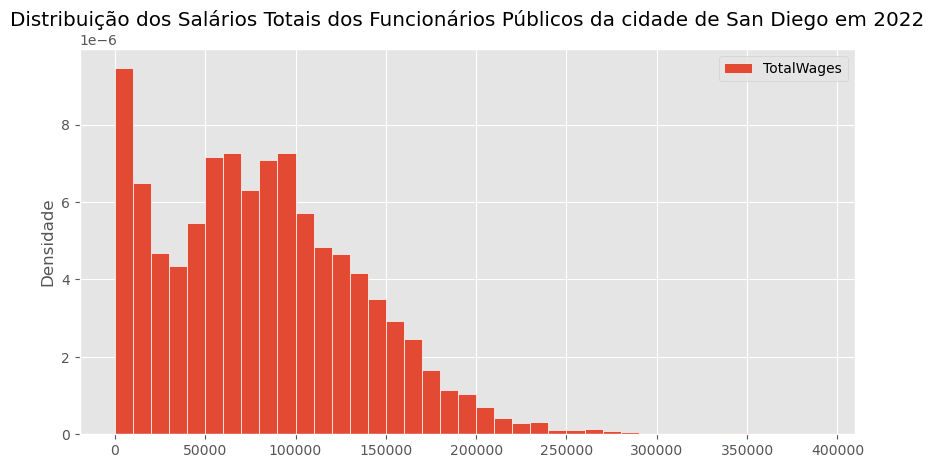

In [9]:
population.plot(kind = 'hist', bins = np.arange(0, 400000, 10000), density = True, ec = 'w', figsize = (10, 5),
                title = 'Distribuição dos Salários Totais dos Funcionários Públicos da cidade de San Diego em 2022')
plt.ylabel('Densidade');

#### Salário mediano na população

- Suponha que estejamos interessados no salário mediano dos funcionários públicos da cidade de San Diego.
- Podemos utilizar a função `.median()` para calcular o salário mediano de todos os funcionários, operando na `Series` `population.get('TotalWages')`.
- Note que, como temos a população _inteira_ disponível, essa mediana é um **parâmetro**, i.e. **não-aleatória**.

In [11]:
population_median = population.get('TotalWages').median()
population_median

78136.0

#### Salário mediano na amostra

- Na prática, porém, o processo de entrevistar **toda** a população (no caso mais de 12,000 funcionários) é caro e pode consumir muito tempo.
- Além disso, muitas vezes é _impossível_ entrevistar todos os indivíduos da população.
- O que fazemos então é aferir os salários com base em uma amostra aleatória (nesse exemplo tomamos $n = 500$).

### Revisão da terminologia

- O DataFrame completo de salários, i.e. `population.get(['TotalWages'])`, é a nossa **população**.

- Nós observamos uma **amostra** de tamanho $n = 500$ dessa população.

- Queremos determinar a **mediana populacional** (que é um _parâmetro_), mas como não temos acesso à população completa, utilizaremos a **mediana amostral** (que é uma _estatística_) como uma **estimativa** desse parâmetro.

- Nesse processo, esperamos que a mediana amostral seja "próxima" da mediana populacional.

### A mediana amostral

Vamos amostrar 500 funcionários aleatoriamente. Para fazer isso, podemos utilizar o método `.sample`.

In [19]:
# Fixando a semente aleatória para garantir reproducibilidade.
np.random.seed(38) 

# Amostrando sem reposição, com n = 500.
my_sample = population.sample(500)
my_sample

,TotalWages
10301,27866
6913,71861
5163,91843
...,...
3002,121209
3718,109709
2394,131409


Nesse notebook, não vamos mais modificar `my_sample`, então esse DataFrame vai sempre se referir à essa amostra em particular.

A mediana amostral dos salários, isto é, a mediana da coluna `TotalWages` em `my_sample`, é igual a:

In [22]:
sample_median = my_sample.get('TotalWages').median()
sample_median

76237.0

### E o quão "confiantes" podemos estar que uma estimativa é uma boa estimativa? 🤔

- Nossa estimativa é função da amostra aleatória particular `my_sample`. Se tívessemos coletado outra amostra, a estimativa poderia ter sido diferente.

- **Agora, o quão diferente nossa estimativa poderia ter sido?** Nosssa _confiança_ na estimativa depende fundamentalmente da resposta à essa pergunta.

- A mediana amostral é um número aleatório. Esse número vem de uma distribuição, que não conhecemos!

- **Se** conhecéssmos a distribuição verdadeira da mediana amostral (i.e. a _distribuição amostral_), essa distribuição nos ajudaria a responder essa pergunta.
    - Distribuições mais "estreitas" (i.e. com baixa _variabilidade/dispersão_) $\Rightarrow$ nossa estimativa em geral não teria sido tão diferente.
    - Distribuições mais "largas" (i.e. com alta variabilidade/dispersão) $\Rightarrow$ nossa estimativa em geral teria sido bem diferente.

### Uma abordagem ineficiente

- Uma ideia natural aqui então seria: coletar repetidas amostras de tamanho $n = 500$ **da população** e calcular as medianas amostrais de cada uma.
- Foi examente isso o que fizemos no Tópico 12, quando calculamos a distribuição empírica amostral das médias amostrais dos atrasos de vôos.

In [29]:
sample_medians = np.array([])
for i in np.arange(1000):
    median = population.sample(500).get('TotalWages').median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([81686.5, 79641. , 75592. , ..., 79350. , 78826.5, 78459.5])

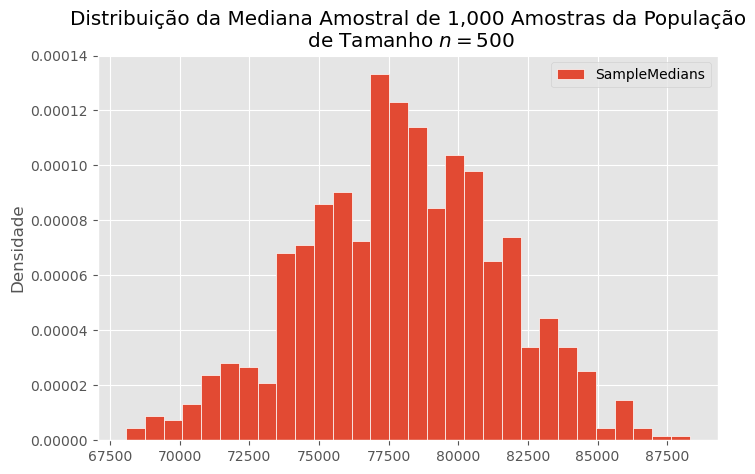

In [30]:
(bpd.DataFrame()
 .assign(SampleMedians = sample_medians)
 .plot(kind = 'hist', density = True,
       bins = 30, ec = 'w', figsize = (8, 5),
       title = 'Distribuição da Mediana Amostral de 1,000 Amostras da População\n de Tamanho $n = 500$')
)
plt.ylabel("Densidade");

- Essa distribuição empírica da mediana amostral é uma _aproximação_ para sua verdadeira distribuição amostral.

### E porque essa abordagem é ineficiente?

- Amostrar repetidas vezes da mesma população muitas vezes é **infactível pelas mesmas razões pelas quais não trabalhamos com a população desde o começo**!
- Se pudéssemos fazer isso, porque não simplesmente coletar mais dados (i.e. uma amostra maior)?

## Bootstrapping 🥾

### Bootstrapping

- **Ideia principal**: Utilizar a amostra no lugar da população.  
    - Nesse caso, _reamostrar da amostra_, de uma certa maneira, é similar à reamostrar da própria população!
    - Denominamos o conjunto de técnicas que se baseiam em reamostragens a partir da amostra de **bootstrapping**.

### Com reposição ou sem reposição?

- Nosso objetivo quando realizamos um bootstrap é gerar uma amostra do _mesmo tamanho_, porém com _algumas características_ diferentes da amostra original.
- Para ilustrar esse ponto, considere um exemplo simples onde vamos reamostrar repetidas vezes **sem reposição**, uma amostra original igual a [1, 2, 3].

In [39]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=False)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [2 1 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0


- Vamos agora repetir o mesmo experimento, mas dessa vez reamostrando **com reposição**:

In [41]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=True)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [3 2 1]     Median:  2.0
Resample:  [1 1 3]     Median:  1.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 1 2]     Median:  1.0
Resample:  [2 1 3]     Median:  2.0
Resample:  [3 3 3]     Median:  3.0
Resample:  [1 1 1]     Median:  1.0
Resample:  [2 2 3]     Median:  2.0
Resample:  [2 3 2]     Median:  2.0
Resample:  [3 3 2]     Median:  3.0


Concluímos com esse exemplo que:
    
- Quando amostramos _sem reposição_, as novas amostras (amostras bootstrap) são em um certo sentido "idênticas" à amostra original – mudamos apenas a ordenação dos indivíduos.
- Como consequência, todas as suas características (isto é, estatísticas), são _iguais_.

- Por outro lado, quando amostramos _com reposição_, as **amostras bootstrap** em geral terão características diferentes da amostra original.
- As estatísticas calculadas nas amostras bootstrap serão em geral _diferentes_ das calculadas na amostra original, o que nos permite aferir _variabilidade das estimativas_ entre as amostras e/ou construir uma distribuição amostral para as estatísticas de interesse.

- Dessa forma, quando realizamos um bootstrap, sempre reamostramos **com reposição**, para garantir que as nossas amostras bootstrap possam ser diferentes da nossa amostra original.
- O bootstrap funciona então como um processo que "imita", em um certo sentido, o ato de coletar novas amostras!

### Bootstrap na amostra de salários

Conforme dito anteriormente, para realizar o bootstrap na nossa amostra basta gerar novas amostras **reamostrando com reposição da nossa amostra original, `my_sample`**:

In [46]:
# Fixando a semente aleatória para garantir reproducibilidade.
np.random.seed(38)

# Número de amostras bootstrap.
n_resamples = 5000
boot_medians = np.array([])

# Loop `for` principal.
for i in range(n_resamples):
    
    # Reamostrando de `my_sample` COM REPOSIÇÃO.
    resample = my_sample.sample(500, replace=True)
    
    # Calculando a mediana da amostra bootstrap.
    median = resample.get('TotalWages').median()
    
    # Salvando o resultado em um array.
    boot_medians = np.append(boot_medians, median)

- No código acima, reamostramos $B = 5000$ vezes da amostra `my_sample` **com reposição**, produzindo $B = 5000$ amostras bootstrap, e logo um array `boot_medians` de tamanho $B = 5000$ contendo a mediana amostral de cada amostra.
- O processo operacional para realizar uma amostragem bootstrap é bem similar ao processo de simulação para estimar probabilidades que vimos no Tópico 11.

Note que em _momento algum_ utilizamos a população `population` aqui! Tudo é feito com **base apenas na amostra** `my_sample`.

In [48]:
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

### _Distribuição bootstrap_ da mediana amostral

Vamos agora elaborar um histograma para visualizar a distribuição bootstrap da mediana amostral:

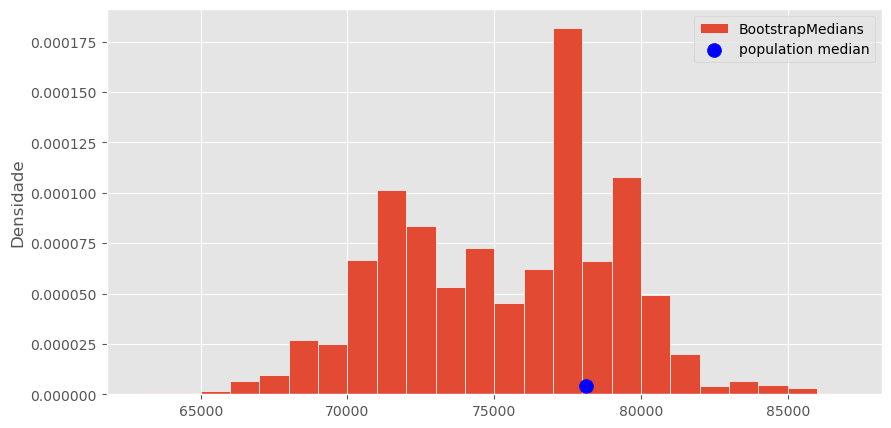

In [51]:
bpd.DataFrame().assign(BootstrapMedians = boot_medians).plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
plt.scatter(population_median, 0.000004, color = 'blue', s = 100, label = 'population median').set_zorder(2)
plt.legend()
plt.ylabel("Densidade");

Apenas para termos uma referência do quão boa é nossa inferência, a mediana populacional é reportada no histograma acima como um <span style="color:blue"><b>ponto azul</b></span>.

**Lembre porém que, na maior parte das situações, não temos acesso à essa informação!**

### Mas afinal, como o bootstrap nos ajuda a responder nossa pergunta original?

Lembre que, aqui, iniciamos apenas com a mediana amostral:

In [54]:
my_sample.get('TotalWages').median()

76237.0

Com base nessa estimativa, podemos dizer apenas que o salário mediano da população é "aproximadamente" \\$76,237, mas não muito mais do que isso.

Em particular, não podemos afirmar nada acerca da _variabilidade_ dessa estimativa, isto é, o quão _confiantes_ (ou incertos!) estamos sobre esse valor.

Com o boostrap, porém, podemos aproximar a **distribuição empírica amostral da mediana amostral**:

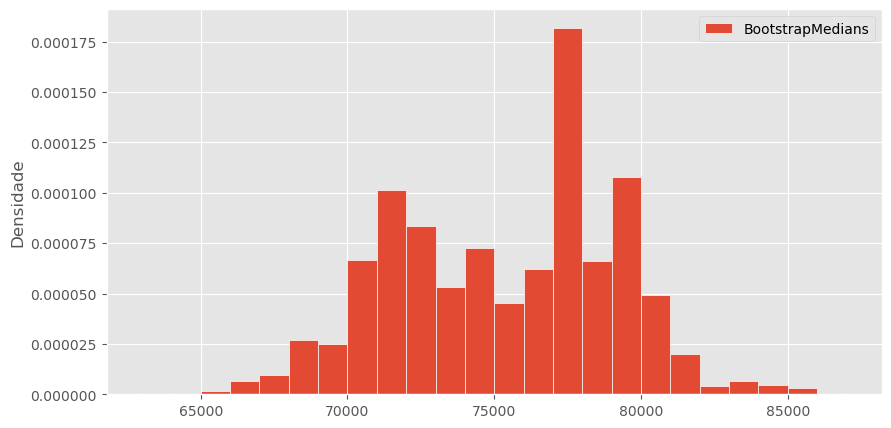

In [57]:
(bpd.DataFrame()
 .assign(BootstrapMedians=boot_medians)
 .plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
)
plt.legend()
plt.ylabel("Densidade");

e essa distribuição nos permite realizar afirmações do tipo

> "Com uma frequência razoável", o salário mediano na população está entre \\$68,000 e \\$82,000.

**Pergunta**: Poderíamos também dizer que o salário mediano na população está entre \\$70,000 e \\$80,000, ou entre \\$65,000 e \\$85,000. Qual desses dois intervalos você reportaria?

## Percentis

### Definição informal

> Seja $p$ um número entre 0 e 100. O $p$-ésimo percentil de um conjunto de observações é o _menor número_ que é maior ou igual a $p\%$ de todos os valores do conjunto.

<center><img src="images/percentile2.jpg" width=600></center>

**Outro exemplo**: Se você está no percentil $80$ da altura de um certo conjunto de pessoas, isso significa que aproximadamente $80\%$ das pessoas desse conjunto são mais baixas que você, e que $20\%$ são mais altas.

<center><img src="images/percentile.svg" width=400></center>

### Calculando percentis

- O pacote `numpy` contém uma função para calcular percentis, `np.percentile(array, p)`, que retorna o `p`-ésimo percentil de `array`. 
- Por enquanto, não entraremos em detalhes sobre como esse valor é calculado: nos concentraremos apenas em utilizar o resultado.

In [65]:
np.percentile([4, 6, 9, 2, 7], 50)

6.0

In [66]:
np.percentile([2, 4, 6, 7, 9], 50)

6.0

Voltando ao nosso exemplo dos salários, temos uma distribuição boostrap da mediana amostral:

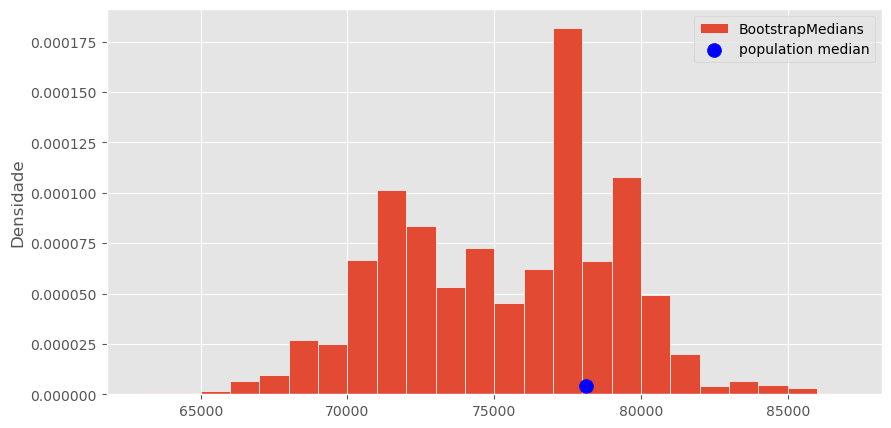

In [68]:
bpd.DataFrame().assign(BootstrapMedians = boot_medians).plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
plt.scatter(population_median, 0.000004, color = 'blue', s = 100, label = 'population median').set_zorder(2)
plt.legend()
plt.ylabel("Densidade");

Com base nessa distribuição, o que podemos então afirmar em termos de percentis?

### Percentis da distribuição bootstrap

- Nossa mediana amostral é igual a \\$76,237.

- Conforme mencionamos anteriormente, acreditamos que a mediana populacional seja _próxima_ de \\$76,237, mas não sabemos _quão_ próxima.

- Como quantificar então a incerteza sobre essa estimativa?

- 💡 **Ideia:** Encontrar um intervalo que contenham **uma certa frequência** (por exemplo $c\%$) das medianas amostrais na distribuição bootstrap. 

Veremos no Tópico 14 um desenvolvimento mais completo dessa ideia, culminando na definição dos **Intervalos de Confiança**.

#### Encontrando percentis da distribuição bootstrap

- No exemplo acima, queremos encontrar um intervalo $[x, y]$ que contenha aproximadamente $c = 95\%$ da área total da distribuição bootstrap.

- Uma maneira* de encontrar esse intervalo é encontrar dois pontos, $x$ e $y$, tais que:
    - A área _à esquerda_ de $x$ na distribuição bootstrap seja aproximadamente $(100\% - 95\%)/2 = 5\%/2 = 2.5\%$.
    - A área _à direita_ de $y$ na distribuição bootstrap seja aproximadamente $(100\% - 95\%)/2 = 5\%/2 = 2.5\%$.
 
*Note que em geral existem **muitos** intervalos $[x, y]$ contendo aproximadamente $c = 95\%$ da distribuição bootstrap!

- Pela definição de percentil dada acima, temos então que $x$ e $y$ são os percentis **2.5** e **97.5** da distribuição bootstrap, respectivamente: 

In [80]:
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

In [81]:
# "Limite inferior": `x`.
x = np.percentile(boot_medians, 2.5)
x

68469.0

In [82]:
# "Limite superior": `y`.
y = np.percentile(boot_medians, 97.5)
y

81253.5

In [83]:
# Intervalo [x, y].
[x, y]

[68469.0, 81253.5]

#### Visualizando os percentis

- Vamos agora sobrepor o intervalo que acabamos de calcular no histograma anterior:

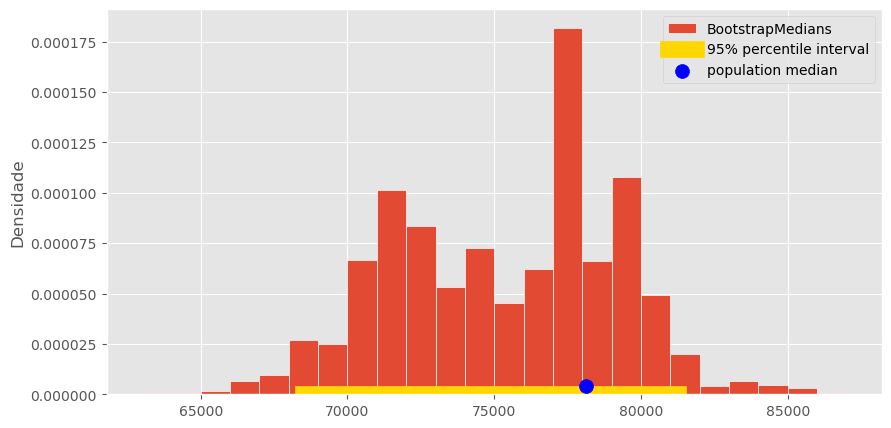

In [85]:
bpd.DataFrame().assign(BootstrapMedians = boot_medians).plot(kind = 'hist', density = True, bins = np.arange(63000, 88000, 1000), ec = 'w', figsize = (10, 5))
plt.plot([x, y], [0, 0], color = 'gold', linewidth = 12, label = '95% percentile interval', zorder = 2);
plt.scatter(population_median, 0.000004, color = 'blue', s = 100, label = 'population median', zorder = 3)
plt.legend()
plt.ylabel("Densidade");

- Podemos então dizer, com "$c = 95\%$ de precisão", que a mediana populacional está entre \\$68,469 e \\$81,253.50, ao invés de simplesmente afirmar que "a mediana populacional é aproximadamente \\$76,237".
- Melhoraremos essa definição no Tópico 14, mas note que isso já nos fornece uma maneira de **quantificarmos a incerteza** sobre nossa estimativa original! 

## "Armadilhas" do bootstrap

### Regras de bolso

- O Bootstrap é uma técnica bem poderosa! Nós apenas precisamos coletar uma única amostra para obter uma distribuição aproximada para a mediana amostral.

Porém, essa técnica tem suas limitações:
- O bootstrap não é muito bom para estatísticas mais "sensíveis" a valores extremos (como por exemplo o máximo, ou o mínimo).
    - Essa técnica funciona melhor para estatísticas que são mais "robustas" (a _outliers_).

- O boostrap fornece bons resultados apenas se a amostra é "suficientemente próxima" da população (o que ocorre se o tamanho amostral $n$ for "suficientemente grande").
    - Se nossa amostra original **não for representativa da população**, as amostras bootstrap também não serão representativas da população!

### Exemplo: Estimando o máximo de uma quantidade populacional

- Suponha que, ao invés da mediana, estejamos agora interessados no _máximo_ dos salários de todos os funcionários públicos da cidade de San Diego (nossa população).
- Nossa amostra coletada continua a mesma que tínhamos anteriormente, `my_sample`.
- Nossa estimativa será igual ao máximo dos salários amostrais (i.e. o maior salário contido na amostra). Esse máximo é uma _estatística_.

- Para obter uma distribuição empírica amostral do máximo, fazemos então o seguinte bootstrap:

In [94]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):
    resample = my_sample.sample(500, replace=True)
    boot_max = resample.get('TotalWages').max()
    boot_maxes = np.append(boot_maxes, boot_max)

In [95]:
boot_maxes

array([339416., 347755., 347755., ..., 257627., 339416., 339416.])

#### Visualizando os resultados

Como aqui temos acesso à população, podemos encontrar o máximo populacional direto (sem bootstrap), apenas para comparação:

In [97]:
population_max = population.get('TotalWages').max()
population_max

384909

Então, será que o máximo populacional se encontra na parte com "mais massa" da distribuição bootstrap?

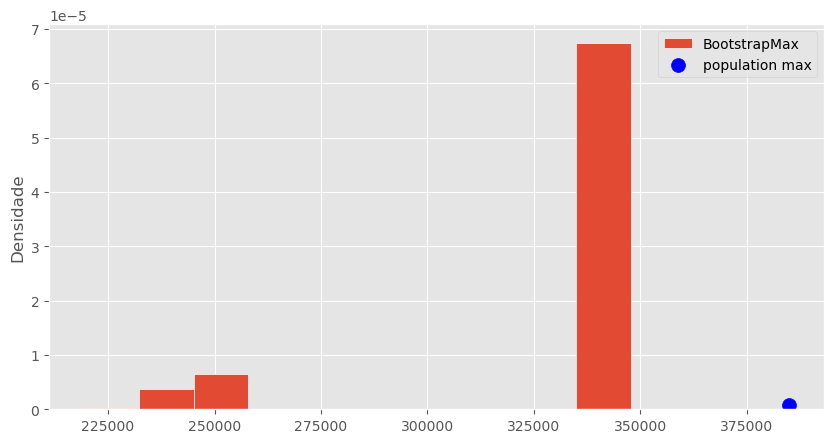

In [99]:
bpd.DataFrame().assign(BootstrapMax = boot_maxes).plot(kind = 'hist', 
                                                     density = True, 
                                                     bins = 10,
                                                     ec = 'w',
                                                     figsize = (10, 5))
plt.scatter(population_max, 0.0000008, color = 'blue', s = 100, label = 'population max')
plt.legend();
plt.ylabel("Densidade");

Na verdade não! A distribuição bootstrap não captura muito bem o máximo populacional, representado no histograma acima pelo <span style="color:blue"><b>ponto azul</b></span> igual a \$384,909.

> E porque não?! 🤔

In [101]:
my_sample.get('TotalWages').max()

347755

- O maior valor na nossa amostra original é de \\$347,755. Logo, o maior valor na nossa amostra bootstrap será no máximo igual a \\$347,755!

- Em geral, o bootstrap funciona melhor para medidas de tendência central ou dispersão (como a média, mediana, desvio padrão, etc.) do que para medidas que são mais sensíveis a outliers, como os extremos (máximo e mínimo).

## Resumo

- Com base em uma amostra, queremos inferir sobre um parâmetro populacional. Porém, como podemos calcular apenas uma estimativa com essa amostra, em geral não sabemos o quão _precisa_ é essa estimativa.
    
- Para termos uma ideia do quão variável é nossa estimativa, idealmente coletaríamos mais amostras e calcularíamos nossa estatística em cada uma dessas amostras. Porém, na prática, amostrar em geral é caro, e logo usualmente temos disponível **apenas uma amostra**.

- **Ideia principal**: Sob certas condições, a amostra é distribuída de maneira bem similar à população da qual a amostra foi coletada. Dessa forma, podemos tratar a distribuição empírica da amostra como se fosse a distribuição populacional e produzir novas amostras **reamostrando** da amostra original.

- Cada nova amostra produzida dessa forma gera nos permite calcular uma nova estimativa. Com base em um conjunto dessas estimativas, podemos então ter uma noção da precisão/variabilidade da nossa estimativa original.

- O **Bootstrap** nos fornece uma maneira de gerarmos uma distribuição empírica de uma estatística, utilizando apenas uma única amostra original. Com base nessa **distribuição bootstrap**, podemos criar intervalos identificando os valores cujo intervalo contenha $c\%$ da distribuição entre si.

- Podemos assim **quantificar a incerteza** sobre nossas estimativas, e fazer afirmações do tipo "a mediana populacional está entre \\$68,469 e \\$81,253.50" com uma certa frequência $c\%$ ao invés de afirmar apenas que "a mediana populacional é aproximadamente \\$76,237".

- O bootstrap funciona bem para estatísticas que não são tão sensíveis à pequenas variações na amostra (tais como a média e a mediana, mas não para máximos e mínimos).